# Scaling Up and Big Data

<h1>Scaling Up and Big Data</h1>

<p>
<b>Quantitative Big Imaging - ETHZ: 227-0966-00L</b>
<br />
</p>
<br />
<p style="font-size:1em;">May 12, 2022</p>
<br /><br />
<p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
<p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.resources import CDN
output_notebook(CDN, hide_banner=True)
local_cluster = False
if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(n_workers=2, threads_per_worker=2)
    client = Client(cluster)
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 72
plt.rcParams["font.size"] = 16
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

## Literature / Useful References

### Big Data

- [Google's Presentation on Distributed Computing](http://www.youtube.com/watch?v=yjPBkvYh-ss&feature=youtu.be)
 - [Slides](http://www.slideshare.net/tugrulh/google-cluster-computing-and-mapreduce-introduction-to-distributed-system-design)
 - [MapReduce Paper](http://citeseerx.ist.psu.edu/viewdoc/summary;jsessionid=110C01079B22F1138DBDB74A20F65AF4?doi=10.1.1.135.4448): Jeffrey Dean, et al. (n.d.). MapReduce: Simplified Data Processing on Large Clusters.
- [Scalable Systems Course](https://courses.cs.washington.edu/courses/cse490h/08au/)
- [Tutorial in Hadoop](http://www.youtube.com/watch?v=KwW7bQRykHI)
- [Intro to Data Science @UCB](http://amplab.github.io/datascience-sp14/)

### Cluster Computing

- [Altintas, I. (2013). Workflow-driven programming paradigms for distributed analysis of biological big data. In 2013 IEEE 3rd International Conference on Computational Advances in Bio and medical Sciences (ICCABS)](doi:10.1109/ICCABS.2013.6629243)
- [Condor High-throughput Computing](http://www.cs.wisc.edu/condor/)
- [Condor Setup at ITET](https://computing.ee.ethz.ch/Services/Condor)
- [Sun (now Oracle) Grid Engine](http://gridscheduler.sourceforge.net/htmlman/manuals.html) or [here](http://wiki.gridengine.info/wiki/index.php/Main_Page)

### Databases

- Ollion, J., Cochennec, J., Loll, F., Escud, C., & Boudier, T. (2013). [TANGO](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3702251&tool=pmcentrez&rendertype=abstract): a generic tool for high-throughput 3D image analysis for studying nuclear organization. Bioinformatics (Oxford, England), 29(14) doi:10.1093/bioinformatics/btt276

### Cloud Computing

- Amazon S3
- Sitaram, D., & Manjunath, G. (2012). Moving To The Cloud. null (Vol. null). Elsevier. doi:10.1016/B978-1-59749-725-1.00006-8
- Duan, P., Wang, W., Zhang, W., Gong, F., Zhang, P., & Rao, Y. (2013). Food Image Recognition Using Pervasive Cloud Computing. In 2013 IEEE International Conference on Green Computing and Communications and IEEE Internet of Things and IEEE Cyber, Physical and Social Computing (pp. 1631-1637). IEEE. doi:10.1109/GreenCom-iThings-CPSCom.2013.296

## Outline

- Motivation
- Computer Science Principles
 - Parallelism
 - Distributed Computing
 - Imperative Programming
 - Declarative Programming
- Organization
 - Queue Systems / Cluster Computing
 - Parameterization
 - Databases
 

- Big Data
 - MapReduce
 - Spark
 - Streaming
- Cloud Computing
- Beyond / The future

## Motivation

There are three different types of problems that we will run into.

### Really big data sets
- Several copies of the dataset need to be in memory for processing
- Computers with more 256GB are expensive and difficult to find
- Even they have 16 cores so still 16GB per CPU
- Drive speed / network file access becomes a limiting factor
- If it crashes you __lose__ everything
 - or you have to manually write a bunch of mess check-pointing code

### Many datasets
- For genome-scale studies 1000s of samples need to be analyzed identically
- Dynamic experiments can have hundreds of measurements 
- Animal phenotyping can have many huge data-sets (1000s of 328GB datasets)
- Radiologist in Switzerland alone make 1 Petabyte of scans per year

### Exploratory Studies
- Not sure what we are looking for
- Easy to develop new analyses
- Quick to test hypotheses

## Example Projects

### Zebra fish Full Animal Phenotyping 
<div class="row">
<div class="column23">
   
__Full adult animal at cellular resolution__
1000's of samples of full adult animals
- Imaged at 0.74 $\mu m$ resolution: 
- Images 11500 x 2800 x 628 
- 20-40GVx / sample!
    
</div>
<div class="column13">
<img src="figures/zebrafish.jpg" style="height:200px"/>
<font size="1">Picture by <a href="https://pixabay.com/users/Kuznetsov_Peter-15644238/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=4996610">Petr Kuznetsov</a> from <a href="https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=4996610">Pixabay</a></font>
<video controls src="movies/fish-scanthrough.mov" type="video/mp4"></video>
</div>
</div>

#### Objectives
- Identification of single cells (no down-sampling)
- Cell networks and connectivity
- Classification of cell type
- Registration with histology

## Brain Project
__Whole brain with cellular resolution__
1 $cm^3$  scanned at 1 $\mu m$ resolution  
Images $\longrightarrow$ 1000 GVx / sample

- Registration separate scans together
- Blood vessel structure and networks
- Registration with fMRI, histology

## What is wrong with usual approaches?

### Inital workflow
Normally when problems are approached they are solved for a single task as quickly as possible
- I need to filter my image with a median filter with a neighborhood of 5 x 5 and a square kernel
- then make a threshold of 10
- label the components
- then count how many voxels are in each component
- save it to a file

```python
im_in     = imread('test.jpg');
im_filter = medfilt2(im_in,[5,5]);
cl_img    = bwlabel(im_filter>10);
cl_count  = hist(cl_img,1:100);
dlmwrite(cl_count,'out.txt')
```

### You want changes in the workflow
- What if you want to compare Gaussian and Median?
- What if you want to look at 3D instead of 2D images?
- What if you want to run the same analysis for a folder of images?


__You have to rewrite everything, everytime__

#### If you start with a bad approach, it is very difficult to fix,
- big data and 
- reproducibility 

must be considered from the beginning

## Computer Science Principles


__Disclosure : There are entire courses / PhD thesis's / Companies about this, so this is just a quick introduction__

- Parallelism
- Distributed Computing
- Resource Contention
 - Shared-Memory
 - Race Conditions
 - Synchronization
 - Dead lock
- Imperative
- Declarative 
 

### What is parallelism?

Parallelism is when you can:
- divide a task into separate pieces 
- which can then be worked on at the same time. 

#### An example 
If you have to walk 5 minutes and talk on the phone for 5 minutes

<img src='figures/walk-talk.svg' style="width:800px"/>

```{figure} figures/walk-talk.pdf
---
scale: 80%
---
Walking and talking as serial and parallel tasks.
```

- you can perform the tasks serially which then takes 10 minutes
- you can perform the tasks in parallel which then takes 5 minutes

Some tasks are easy to parallelize while others are very difficult. 

Rather than focusing on programming, real-life examples are good indicators of difficultly.

## What is distributed computing?

Distributed computing is very similar to parallel computing, but a bit more particular. 
- Parallel means you process many tasks at the same time, 
- Distributed means you are no longer on the same CPU, process, or even on the same machine.

The distributed has some important implications since once you are no longer on the same machine the number of variables like 
- network delay, 
- file system issues, 
- and other users on the system

becomes a major problem.

### Distributed Computing Examples


1. You have 10 friends who collectively know all the capital cities of the world.
 - To find the capital of a single country you just yell the country and wait for someone to respond (+++)
 - To find who knows the most countries, each, in turn, yells out how many countries they know and you select the highest (++)
 


2. Each friend has some money with them
 - To find the total amount of money you tell each person to tell you how much money they have and you add it together (+)
 - To find the __median__ coin value, you ask each friend to tell you you all the coins they have and you make one master list and then find the median coin (-)

## Resource Contention

The largest issue with parallel / distributed tasks is the need to access the same resources at the same time

- memory / files
- pieces of information
- network resources


### Dead-lock
[Dining Philopher's Problem](http://en.wikipedia.org/wiki/Dining_philosophers_problem)
<img src="figures/An_illustration_of_the_dining_philosophers_problem.png" alt="Benjamin D. Esham / <a href='https://creativecommons.org/licenses/by-sa/3.0'>Wikimedia Commons, CC BY-SA 3.0</a>, via Wikimedia Commons" style="height:250px" />
- 6 philosophers at the table
- 6 forks
- Everyone needs two forks to eat
- Each philospher takes the fork on his left

### Challenges in parallel processing

#### 1. Coordination
Parallel computing requires a significant of coordinating between computers for non-easily parallelizable tasks.

#### 2. Mutability
The second major issue is mutability, if you have two cores / computers trying to write the same information at the same it is no longer deterministic (not good)

#### 3. Blocking
The simple act of taking turns and waiting for every independent process to take its turn can completely negate the benefits of parallel computing

## Parallel speedup and slowdown
Depend on:
- Available resources
- Implementation
- Scheduling

In [2]:
nCPU     = np.linspace(1,8,8)
speedup  = np.array([1,2,3,4,5,6,7,8])
realspeedup = 0.9 * speedup + 0.1
realspeedup[5:] = np.array([5.2, 5.5, 5])

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('# CPUs')
ax1.set_ylabel('Processing time')
ax1.plot(nCPU, 1/speedup,marker="o", color="limegreen",label = 'Ideal processing time' )
ax1.plot(nCPU, 1/realspeedup,marker="o",linewidth=3,color="seagreen", label = 'Real processing time' )

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Speedup')  # we already handled the x-label with ax1
ax2.plot(nCPU, speedup, marker="o",color="cornflowerblue", label = 'Ideal speedup')
ax2.plot(nCPU, realspeedup, marker="o", linewidth=3,color="navy",label = 'Real speedup')
ax1.axvline(x=5,linewidth=1, color='darkorange', ymax=0.9)
ax1.axvline(x=7,linewidth=1, color='crimson',ymax=0.9)
fig.legend();
ax1.set_title("Performance of parallel computing");


NameError: name 'np' is not defined

### Real performance test run - Spotting hotspots

<div class="row">
<div class="column">

__A time consuming component__
        
<img src="figures/timepertask.png" style="height:500px"/>
</div>
<div class="column">
        
__Introduced parellel code__
        
<img src="figures/timepertask_parallelRingClean.png" style="height:500px"/>
</div>
</div>

The two graphs show the execution time of a tomographic reconstruction as a system task including data IO and preprocessing. Splitting the timing per task in this way makes it possible to identify which part of the processing that consumes much processing time. In this example it appears that the single threaded implementation of the ring cleaning algorithm is takes a dominant fraction of the total processing time. This is therefore the target of tuning. There is a remarkable speed-up by distibuting the task on the available cores. 

This example, there are components that are easy parallelize by altering the algorithm while others are harder. The yellow block labelled "other" mainly represents the time needed to read input data and to store the results. This brings us to take a closer look at Amdahls law.

### Theoretical speed-up - Amdahl's law

<div class="row">
<div class="column23">

The code can be divided into two parts:
- sequential
- parallelizable

$$S_{latency}(s) = \frac{1}{(1-p)+\frac{p}{s}}$$
    
$p$ - time consumed by paralleizable code  
$s$ - number of cores
</div>
<div class="column13">
    <img src="figures/amdahl.svg" style="height:400px"/>
</div>
</div>


## Challenges in distributed processing


Inherits all of the problems of parallel programming with a whole variety of new issues.

### Sending Instructions / Data Afar

### Fault Tolerance
If you have 1000 computers working on solving a problem and one fails, you do not want your whole job to crash

### Data Storage

How can you access and process data from many different computers quickly without very expensive infrastructure

# Programming paradigms

## Imperative Programming


Directly coordinating tasks on a computer. 

- Languages like C, C++, Java, Matlab
- Exact orders are given (implicit time ordering)
- Data management is manually controlled
- Job and task scheduling is manual
- Potential to tweak and optimize performance


### Making a soup (from lecture 1)

1. Buy vegetables at market
1. _then_ Buy meat at butcher
1. _then_ Chop carrots into pieces
1. _then_ Chop potatos into pieces
1. _then_ Heat water
1. _then_ Wait until boiling then add chopped vegetables
1. _then_ Wait 5 minutes and add meat

## Declarative 


- Languages like SQL, Erlang, Haskell, Scala, Python, R can be declarative
- Goals are stated rather than specific details
- Data is automatically managed and copied
- Scheduling is automatic but not always _efficient_



### Making a soup (from lecture 1)
- Buy vegetables at market $\rightarrow shop_{veggies}$ 
- Buy meat at butcher $\rightarrow shop_{meat}$ 
- Wait for $shop_{veggies}$: Chop carrots into pieces $\rightarrow chopped_{carrots}$
- Wait for $shop_{veggies}$: Chop potatos into pieces $\rightarrow chopped_{potatos}$
- Heat water
- Wait for $boiling water$,$chopped_{carrots}$,$chopped_{potatos}$: Add chopped vegetables
 - Wait 5 minutes and add meat
 

## Comparison

They look fairly similar, so what is the difference? 

<table>
<cols width=500px />
    
<tr><th> 
    
### Imperative soup

</th><th>
    
### Declarative soup

</th></tr>
<tr><td>
    
1. Buy {carrots, peas, tomatoes} at market
1. _then_ Buy meat at butcher
1. _then_ Chop carrots into pieces
1. _then_ Chop potatos into pieces
1. _then_ Heat water
1. _then_ Wait until boiling then add chopped vegetables
1. _then_ Wait 5 minutes and add meat  

</td><td>

- Buy {carrots, peas, tomatoes} at market $\rightarrow shop_{veggies}$ 
- Buy meat at butcher $\rightarrow shop_{meat}$ 
- Wait for $shop_{veggies}$: Chop carrots into pieces $\rightarrow chopped_{carrots}$
- Wait for $shop_{veggies}$: Chop potatos into pieces $\rightarrow chopped_{potatos}$
- Heat water
- Wait for $boiling_{water}$,$chopped_{carrots}$,$chopped_{potatos}$: Add chopped vegetables
 - Wait 5 minutes and ,$shop_{meat}$: add meat

</td></tr>
</table>

The second is needlessly complicated for one person, but what if you have a team:
- how can several people make an imperative soup faster (chopping vegetables together?)

- How can many people make a declarative soup faster? Give everyone a different task (not completely efficient since some tasks have to wait on others)


 

## Results


### Imperative
- optimize specific tasks (chopping vegetables, mixing) so that many people can do it faster
 - Matlab/Python do this with fast-fourier-transforms (automatically uses many cores to compute faster)
- make many soups at the same time (independent)
 - This leads us to cluster-based computing
 

### Declarative
- run everything at once
- each core (computer) takes a task and runs it
- execution order does not matter
 - wait for portions to be available (dependency)

### Lazy Evaluation
- do not run anything at all
- until something needs to be exported or saved
- run only the tasks that are needed for the final result
 - never buy tomatoes since they are not in the final soup

# Organization


One of the major challenges of scaling up experiments and analysis is keeping all of the results organized in a clear manner. 

As we have seen in the last lectures, many of the results produced many text files

- many files are difficult to organize
- Matlab, R are designed for in-memory computation
- Datasets can have many parameters and be complicated
- Transitioning from Excel to Matlab or R means rewriting everything

## Queue Computing


Queue processing systems (like Sun Grid Engine, Oracle Grid Engine, Apple XGrid, Condor, etc) are used to manage 

<table>
<cols width=500px />
    
<tr><th> 
    
__Resources__

</th><th>
    
__Jobs__

</th><th>
    
__Users__
    
</th></tr>

<tr><td>
    
computers, memory, storage

</td><td>

tasks to be run

</td><td>
    
 

</td></tr>

<tr><td>
    
- a collection of processors (CPU and GPU)
- memory, local storage 
- access to bandwidth or special resource like a printer
- for a given period of time

<center>
<img src="figures/noun_resources.svg" style="height:170px" />
</center>
</td><td>

- specific task to run
- necessary (minimal/maximal) resources to run with
 - including execution time

<center>
<img src="figures/noun_job.svg" style="height:200px" />
</center>
</td><td>
    
- accounts submitting jobs
- it can be undesirable for one user to dominate all of the resources all the time 

<center>
<img src="figures/noun_queue.svg" style="height:300px" />
</center>
</td></tr>
</table>

Based on a set of rules for how to share the resources to the users to run tasks. 



## Structure of Cluster


### Master (or Name) Node(s)
The node with which every other node communicates, the main address.

### Worker Nodes
The nodes where the computation is performed. 

### Scheduler
The actual process that decides which jobs will run using which resources (worker nodes, memory, bandwidth) at which time

# Databases

A database is a collection of data stored in the format of tables: 
- a number of columns (data categories in the table)
- and rows (stored items)

In [3]:
from IPython.display import display, Markdown
import pandas as pd
display(Markdown('### Animals\nHere we have an table of the animals measured in an experiment and their weight'))
display(pd.DataFrame(dict(id=(1, 2, 3),
                          Weight=(100, 40, 80)
                          )))

display(Markdown(
    '### Cells\nThe cells is then an analysis looking at the cellular structures'))

display(pd.DataFrame(dict(
    Animal=( 1, 2, 3),
    Type=("Cancer", "Healthy", "Cancer"),
    Anisotropy=(0.5, 1.0, 0.5),
    Volume=(1, 2, 0.95))))

### Animals
Here we have an table of the animals measured in an experiment and their weight

,id,Weight
0,1,100
1,2,40
2,3,80


### Cells
The cells is then an analysis looking at the cellular structures

,Animal,Type,Anisotropy,Volume
0,1,Cancer,0.5,1.00
1,2,Healthy,1.0,2.00
2,3,Cancer,0.5,0.95


## SQL


SQL (pronounced Sequel) stands for __S__tructured __Q__uery __L__anguage and is _nearly_ universal for both 
- searching (called querying) 
- and adding (called inserting) data into databases. 

SQL is used in various forms from 
- Firefox storing its preferences locally (using SQLite) 
- to Facebook storing some of its user information (MySQL and Hive). 

So refering to the two tables we defined in the last entry, we can use SQL to get information about the tables independently of how they are stored (a single machine, a supercomputer, or in the cloud)

### SQL -  Basic queries

- Get the volume of all cells

```sql
SELECT Volume FROM Cells
```

$$ \rightarrow \begin{bmatrix} 1,2,0.95\end{bmatrix} $$

- Get the average volume of all cancer cells

```sql
SELECT AVG(Volume) FROM Cells WHERE Type = "Cancer"
```

$$ \rightarrow 0.975 $$

We could have done these easily without SQL using Excel, Matlab or R

### More Advanced SQL



- Get the volume of all cells in heavy mice
```sql
SELECT Volume FROM Cells WHERE Animal IN 
  (SELECT id FROM Animal WHERE Weight>80)
```

- Get weight and average cell volume for all mice

```sql
SELECT ATable.Weight,CTable.Volume FROM Animals as ATable 
  INNER JOIN Cells as CTable on (ATable.id=CTable.Animal)
```



$$ \rightarrow \begin{bmatrix} 1,0.95\end{bmatrix} $$

## Beyond SQL: NoSQL


Basic networks can be entered and queries using SQL but relatively simple sounding requests can get complicated very quickly

### Network Analysis
If we try to store cells and their connections in a SQL database, we can handle millions of cells and connections easily in a structured manner. However trying to perform analysis is trickier

- *How many cells are within two connections of each cell*
```
SELECT id,COUNT(*) AS connection_count FROM Cells as CellsA
  INNER JOIN Network as NetA ON Where (id=NetA.id1)
  INNER JOIN Network as NetB ON Where (NetA.id2=NetB.id1)
```

This is _still_ readable but becomes very cumbersome quickly and difficult to manage

### NoSQL (Not Only SQL)

A new generation of database software which extends the functionality of SQL to allow for more scalability (MongoDB) or specificity for problems like networks or graphs called generally **Graph Databases**

# Big Data

## Definition

### Velocity, Volume, Variety
When a ton of heterogeneous is coming in fast. We need:
- __Performant__
- __Scalable__ 
- __Flexible__

### When scaling isn't scary
10X, 100X, 1000X is the same amount of effort

### When you are starving for enough data
Director of AMPLab said their rate limiting factor is always enough interesting data

### No 'clicks' per sample
Everything is automated, no human interaction required during processing

## A brief oversimplified story


Google ran into 'big data' and its associated problems years ago: 
- Peta- and exabytes of websites to collect and make sense of. 
- Google uses an algorithm called PageRank(tm) for evaluating the quality of websites. 

They could have probably used existing tools if page rank were some magic program that could read and determine the quality of a site

```
for every_site_on_internet
  current_site.rank=secret_pagerank_function(current_site)
end
```

Just divide all the websites into a bunch of groups and have each computer run a group, **easy!**

### PageRank

While the actual internals of PageRank are not public, the general idea is that sites are ranked based on how many sites link to them

```
for current_site in every_site_on_internet
  current_pagerank = new SecretPageRankObj(current_site);
  for other_site in every_site_on_internet
    if current_site is_linked_to other_site
      current_pagerank.add_site(other_site);
    end
  end
  current_site.rank=current_pagerank.rank();
end
```
Complexity $O(N^2)$

### How do you divide this task? 
- Maybe try and divide the sites up: english_sites, chinese_sites, ...
 - Run pagerank and run them separately.
 - What happens when a chinese_site links to an english_site? 
- Buy a really big, really fast computer?
 - On the most-powerful computer in the world, one loop would take months

### It gets better

- What happens if one computer / hard-drive crashes?
 - Have a backup computer replace it (A backup computer for every single system)
 - With a few computers ok, with hundreds of thousands of computers?
 - What if there is an earthquake and all the computers go down?
- PageRank doesn't just count
 - Uses the old rankings for that page
 - Run pagerank many times until the ranks converge

### Google's Solution: MapReduce (part of it)

__some people claim to have had the idea before, Google is certainly the first to do it at scale__

Several engineers at Google recognized common elements in many of the tasks being performed. They then proceeded to divide all tasks into two classes **Map** and **Reduce**

#### Map
Map is where a function is applied to every element in the list and the function depends only on exactly that element
$$ \vec{L} = \begin{bmatrix} 1,2,3,4,5 \end{bmatrix} $$
$$ f(x) = x^2 $$
$$ map(f \rightarrow \vec{L}) = \begin{bmatrix} 1,4,9,16,25 \end{bmatrix} $$



#### Reduce

Reduce is more complicated and involves aggregating a number of different elements and summarizing them. For example the $\Sigma$ function can be written as a reduce function
$$ \vec{L} = \begin{bmatrix} 1,2,3,4,5 \end{bmatrix} $$
$$ g(a,b)  = a+b $$
Reduce then applies the function to the first two elements, and then to the result of the first two with the third and so on until all the elements are done
$$ reduce(f \rightarrow \vec{L}) = g(g(g(g(1,2),3),4),5) $$

## MapReduce

Google designed a framework for handling distributing and running such of jobs on clusters. 

So for each job a dataset ($\vec{L}$), Map-task ($f$), a grouping, and Reduce-task ($g$) are specified

1. Partition input data ($\vec{L}$) into chunks across all machines in the cluster
2. Apply **Map** ($f$) to each element
3. Shuffle and Repartition or Group Data 
4. Apply **Reduce** ($g$) to each group
5. Collect all of the results and write to disk

All of the steps in between can be written once in a robust, safe manner and then used for every task which can be described using this MapReduce paradigm. 

These tasks $\langle \vec{L}, f(x), g(a,b) \rangle$ is refered to as a job. 

## Key-Value Pairs / Grouping

The initial job was very basic, for more complicated jobs, a new notion of Key-value (KV) pairs must be introduced. 

A KV pair is made up of a key and value: 
- A key must be comparable / hashable (a number, string, immutable list of numbers, etc) and is used for grouping data. 
- The value is the associated information to this key. 

## Counting Words

Using MapReduce on a folder full of text-documents: 
$$ \vec{L} = \begin{bmatrix} "\textrm{Info}\cdots", "\textrm{Expenses}\cdots",\cdots \end{bmatrix} $$
### Map
is then a function $f$ which takes in a long string and returns a list of all of the words (text seperated by spaces) as key-value pairs with the value being the number of times that word appeared

```python 
f(x) = [(word,1) for word in  x.split(" ")]
```

Grouping is then performed by keys (group all words together)

### Reduce
adds up the values for each word


#### Workflow
```python 
L = ["cat dog car",
     "dog car dog"]
```
$$ \downarrow \textbf{ Map } : f(x) $$

```[("cat",1),("dog",1),("car",1),("dog",1),("car",1),("dog",1)] ```

$$ \downarrow \textrm{ Shuffle / Group} $$

```"cat": (1)
 "dog": (1,1,1)
 "car": (1,1)```
$$ \downarrow \textbf{ Reduce } : g(a,b) $$
```[("cat",1),("dog",3),("car",2)]```

### Word Count Example
Here we make a word count example using all the lines of Shakespeare's "A midsommer-night's dream"

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/Oberon%2C_Titania_and_Puck_with_Fairies_Dancing._William_Blake._c.1786.jpg/1200px-Oberon%2C_Titania_and_Puck_with_Fairies_Dancing._William_Blake._c.1786.jpg" style="height:200px" />

In [4]:
import os
shake_path = 'data/shakespeare.txt'
with open(shake_path, 'r') as f:
    all_lines = f.readlines()
    
print(all_lines[:5])

["A MIDSUMMER-NIGHT'S DREAM\n", '\n', 'Now , fair Hippolyta , our nuptial hour \n', 'Draws on apace : four happy days bring in \n', 'Another moon ; but O ! methinks how slow \n']


### Imperative / Serial Execution
Here we run the code in an imperative fashion one line at a time.

In [5]:
from tqdm.notebook import tqdm
from collections import defaultdict
import string
word_count = defaultdict(lambda: 0)  # default count is 0
for c_line in tqdm(all_lines):
    for c_word in c_line.lower().strip().split(' '):
        v_word = ''.join([c for c in c_word if c in string.ascii_lowercase])
        if len(v_word) > 0:
            word_count[v_word] += 1

  0%|          | 0/129107 [00:00<?, ?it/s]

#### Analysis results

In [6]:
print('Shakespeare used', len(word_count), 'different words')
print('Most frequent')
for w, count in sorted(word_count.items(), key=lambda x: -x[1])[:10]:
    print(w, '\t', count)
print('\nLeast frequent')
for w, count in sorted(word_count.items(), key=lambda x: x[1])[:10]:
    print(w, '\t', count)

Shakespeare used 26982 different words
Most frequent
the 	 26851
and 	 24077
i 	 20535
to 	 18561
of 	 16013
you 	 13856
a 	 13840
my 	 12282
that 	 10761
in 	 10537

Least frequent
midsummernights 	 1
wanes 	 1
newbent 	 1
solemnities 	 1
merriments 	 1
interchangd 	 1
lovetokens 	 1
prevailment 	 1
unhardend 	 1
filchd 	 1


### MapReduce Approach
Here we use the Map Reduce approach to divide the function up into Map and Reduce components

First we need a function to convert lines to words:

In [7]:
import doctest
import copy
import functools
# tests are very important for map reduce

def autotest(func):
    globs = copy.copy(globals())
    globs.update({func.__name__: func})
    doctest.run_docstring_examples(
        func, globs, verbose=True, name=func.__name__)
    return func

In [8]:
# map function
@autotest
def line_to_words(in_line):
    """
    Takes a single line and returns the words and counts
    >>> line_to_words("hi i am. bob .  ")
    ['hi', 'i', 'am', 'bob']
    """
    words = in_line.lower().strip().split(' ')
    v_words = [''.join([c for c in c_word if c in string.ascii_lowercase])
               for c_word in words]
    return [c_word for c_word in v_words if len(c_word) > 0]

Finding tests in line_to_words
Trying:
    line_to_words("hi i am. bob .  ")
Expecting:
    ['hi', 'i', 'am', 'bob']
ok


## MapReduce approach using Dask bags
Dask Bag implements operations like 
- map, 
- filter, 
- fold, 
- and groupby 
on collections of generic Python objects.

Execution on bags provide two benefits:

- Parallel: data is split up, allowing multiple cores or machines to execute in parallel
- Iterating: data processes lazily, allowing smooth execution of larger-than-memory data, even on a single machine within a single partition

### Build a bag for the word analysis

In [9]:
import dask.bag as dbag
line_bag = dbag.from_sequence(all_lines, partition_size=10000)
line_bag

dask.bag<from_sequence, npartitions=13>

In [10]:
map_output = line_bag.map(line_to_words).flatten()
map_output

dask.bag<flatten, npartitions=13>

In [11]:
# we cheat a bit for the reduce step
reduce_output = map_output.frequencies()
top10 = reduce_output.topk(10, lambda x: x[1])
bot10 = reduce_output.topk(10, lambda x: -x[1])

### Run the analysis

In [12]:
import dask.diagnostics as diag

workers = 10

with diag.ProgressBar(), diag.Profiler() as prof, diag.ResourceProfiler(0.5) as rprof:
    print('Top 10\n', top10.compute(num_workers=workers))
    print('Bottom 10\n', bot10.compute(num_workers=workers))

[########################################] | 100% Completed |  0.7s
Top 10
 [('the', 26851), ('and', 24077), ('i', 20535), ('to', 18561), ('of', 16013), ('you', 13856), ('a', 13840), ('my', 12282), ('that', 10761), ('in', 10537)]
[########################################] | 100% Completed |  0.7s
Bottom 10
 [('midsummernights', 1), ('wanes', 1), ('newbent', 1), ('solemnities', 1), ('merriments', 1), ('interchangd', 1), ('lovetokens', 1), ('prevailment', 1), ('unhardend', 1), ('filchd', 1)]


### Visualize parallel task distribution

In [13]:
diag.visualize([prof, rprof]);

# Environments for distributed computing

## Hadoop


Hadoop is the opensource version of MapReduce developed by Yahoo and released as an Apache project. 

It provides underlying infrastructure and filesystem that handles storing and distributing data so each machine stores some of the data locally and processing jobs run where the data is stored. 
- Non-local data is copied over the network. 
- Storage is automatically expanded with processing power.
- It's how Amazon, Microsoft, Yahoo, Facebook, ... deal with exabytes of data

## Spark / Resilient Distributed Datasets


### Technical Specifications

- Developed by the Algorithms, Machines, and People Lab at UC Berkeley in 2012
- General tool for all Directed Acyclical Graph (DAG) workflows
- Course-grained processing $\rightarrow$ simple operations applied to entire sets
 - Map, reduce, join, group by, fold, foreach, filter,...
- In-memory caching

<small>Zaharia, M., et. al (2012). Resilient distributed datasets: a fault-tolerant abstraction for in-memory cluster computing</small>


### Practical Specification
- Distributed, parallel computing without __logistics__, libraries, or compiling
- Declarative rather than imperative
 - Apply operation $f$ to each image / block
 - __NOT__ tell computer 3 to wait for an image from computer 2 to and perform operation $f$ and send it to computer 1
 - Even scheduling is handled automatically
- Results can be stored in memory, on disk, redundant or not

## Dask 
In the pure python ecosystem, there has been a recent development called Dask.

Dask aims to bring 
- the fault-tolerant,
- robust distributed computing 

to numerical python codes. 

In particular the focus has been on taking libraries like numpy and scipy and making them run as easily as possible in a distributed setting.

We will use these for the examples but they can be applied equally well to Spark and Hadoop-like problems.

## DAGs
More general than the MapReduce structure is the idea of making directed acyclical graphs. 

These are used in 
- Spark, 
- Dask for distributed computing 
- and in Tensorflow and PyTorch 

for massively parallel computing since it allows complex operations to be defined in a declarative way.

This allows them to be optimized later depending on the actual resources available (and re-executed if some of those resources crash).

### Some resources
- PyData Dask - https://dask.pydata.org/en/latest/
- Apache Spark - https://spark.apache.org/
- Spotify Luigi - https://github.com/spotify/luigi
- Airflow - https://airflow.apache.org/
- KNIME - https://www.knime.com/
- Google Tensorflow - https://www.tensorflow.org/
- Pytorch / Torch - http://pytorch.org/

## Tensor Comprehensions
Facebook shows an example of why such representations are useful since they allow for the operations to be optimized later and massive performance improvements even for _fairly_ basic operations. 

<img src="https://research.fb.com/wp-content/uploads/2018/02/tc_evol_slower.gif" />

## DAG examples

### A basic DAG

Create two 5x5 images and use a single chunk: 
- image1 all elements = 0
- image2 all elements = 1

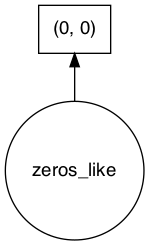

In [14]:
import dask.array as da
from dask.dot import dot_graph
image_1 = da.zeros((5, 5), chunks=(5, 5))
image_2 = da.ones((5, 5), chunks=(5, 5))
dot_graph(image_1.dask)

### Image arithmetics

We want to compute:
    $$image_4 = (image_1-10) + (image_2*50)$$

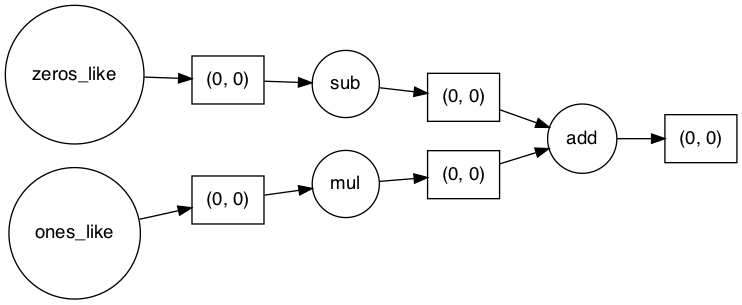

In [15]:
image_4 = (image_1-10) + (image_2*50)
dot_graph(image_4.dask,rankdir="LR")

### More calculations

$$image_5 = image_1 * image_4$$

#### Remember    
$$image_4 = (image_1-10) + (image_2*50)$$

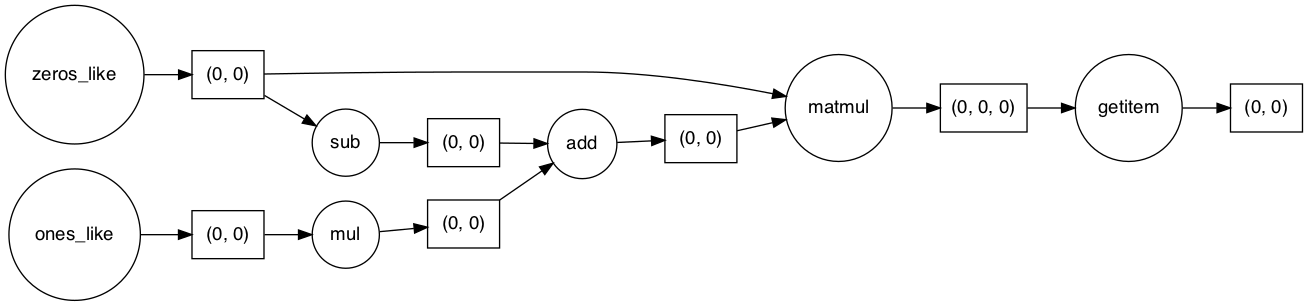

In [16]:
image_5 = da.matmul(image_1, image_4)
dot_graph(image_5.dask,rankdir="LR")

## Image Processing using DAGs
the initial examples were shown on very simple image problems. 

Here we can see how it looks for real imaging issues.

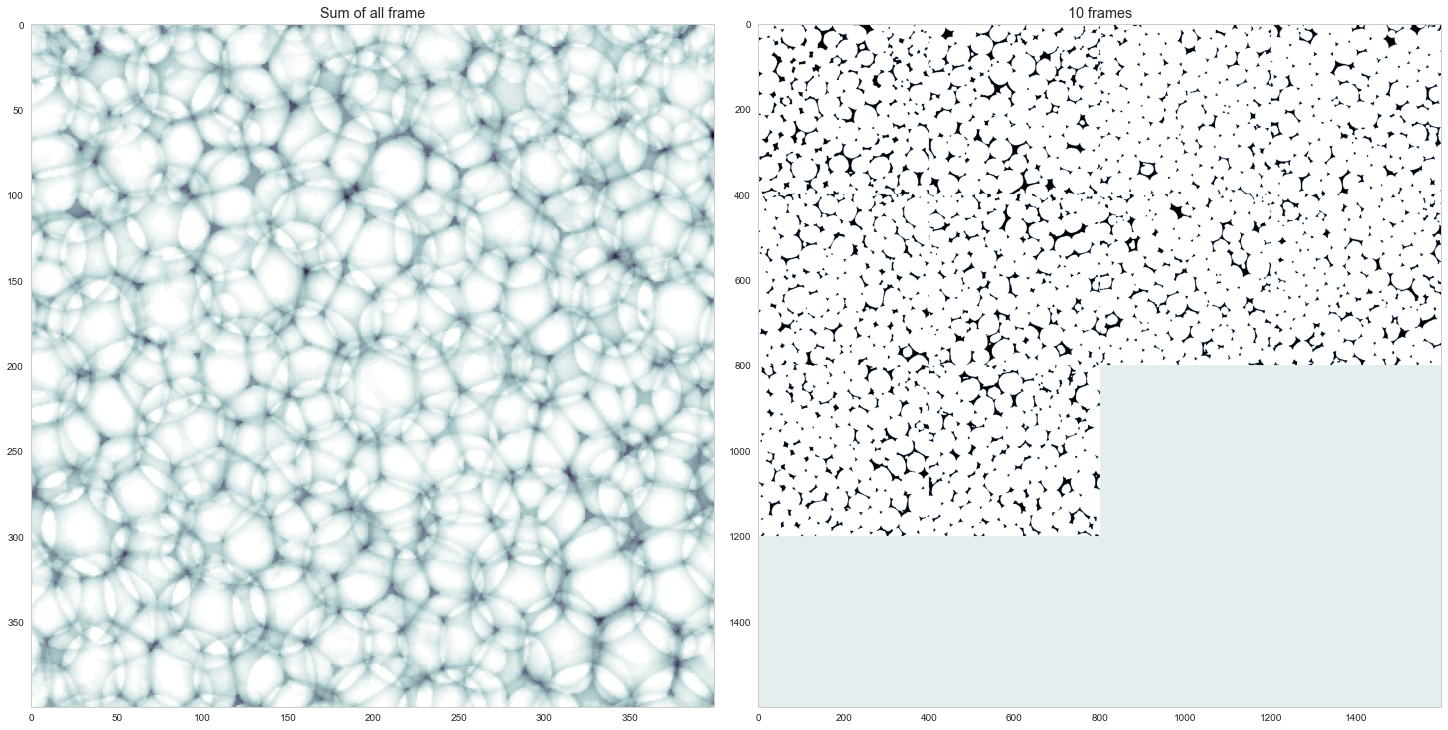

In [17]:
%matplotlib inline
import dask.array        as da
from   dask.dot          import dot_graph
import numpy             as np
from   skimage.io        import imread
import matplotlib.pyplot as plt
from   skimage.util      import montage as montage2d
# for showing results
import dask.diagnostics as diag

foam_stack = imread('data/plateau_border.tif')[:-54, 52:-52, 52:-52]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(np.sum(foam_stack, 0), cmap='bone_r'), ax1.set_title('Sum of all frame')
ax2.imshow(montage2d(foam_stack[::10]), cmap='bone_r'), ax2.set_title('10 frames');

In [19]:
from itkwidgets import view
from IPython.display import display
import itk

if True:
    viewer = view(itk.GetImageFromArray(foam_stack.copy()))
    display(viewer)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

## Create a DAG with the foam image

- The image is 100x400x400
- We want 20 slices per chunk
- Scale intensities to from [0,255] to [0,1]

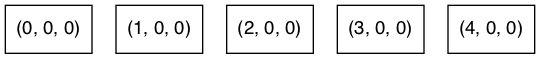

In [20]:
da_foam = da.from_array(
    foam_stack/255.0, chunks=(20, 400, 400), name='FoamImage')
dot_graph(da_foam.dask)

### Add filter operation

- We want to use the Dask version of scipy.ndfilter.gaussian_filter

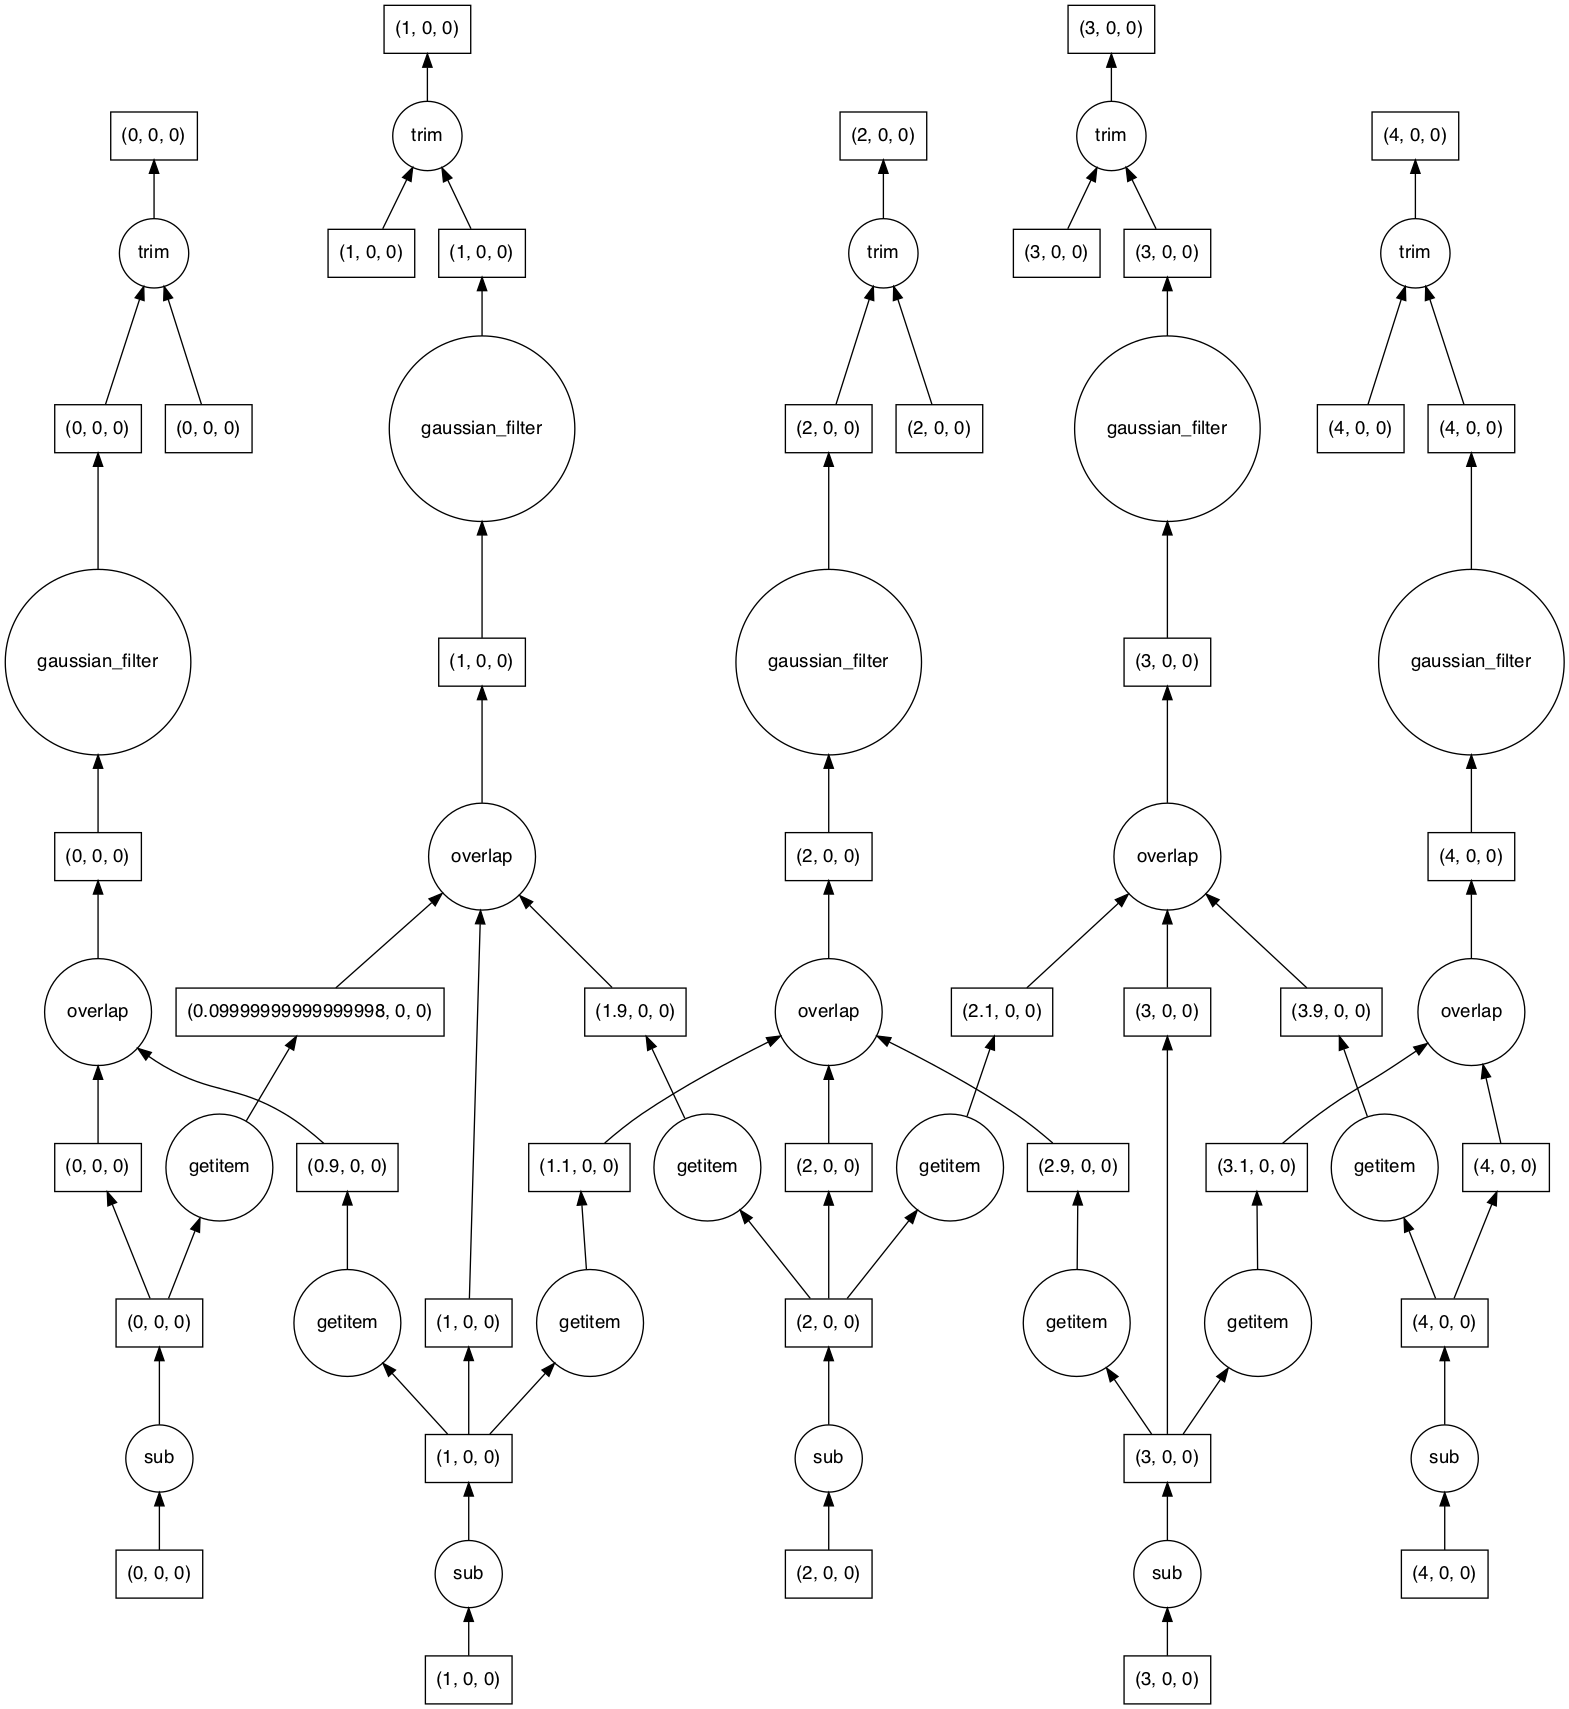

In [22]:
import dask_ndfilters as da_ndfilt
image_filt = da_ndfilt.gaussian_filter(1-da_foam, sigma=(3, 6, 6))
dot_graph(image_filt.dask)

### Add segment and erode to the DAG
- Apply a threshold at 0.9
- Erode with a ball structure element with radius 12

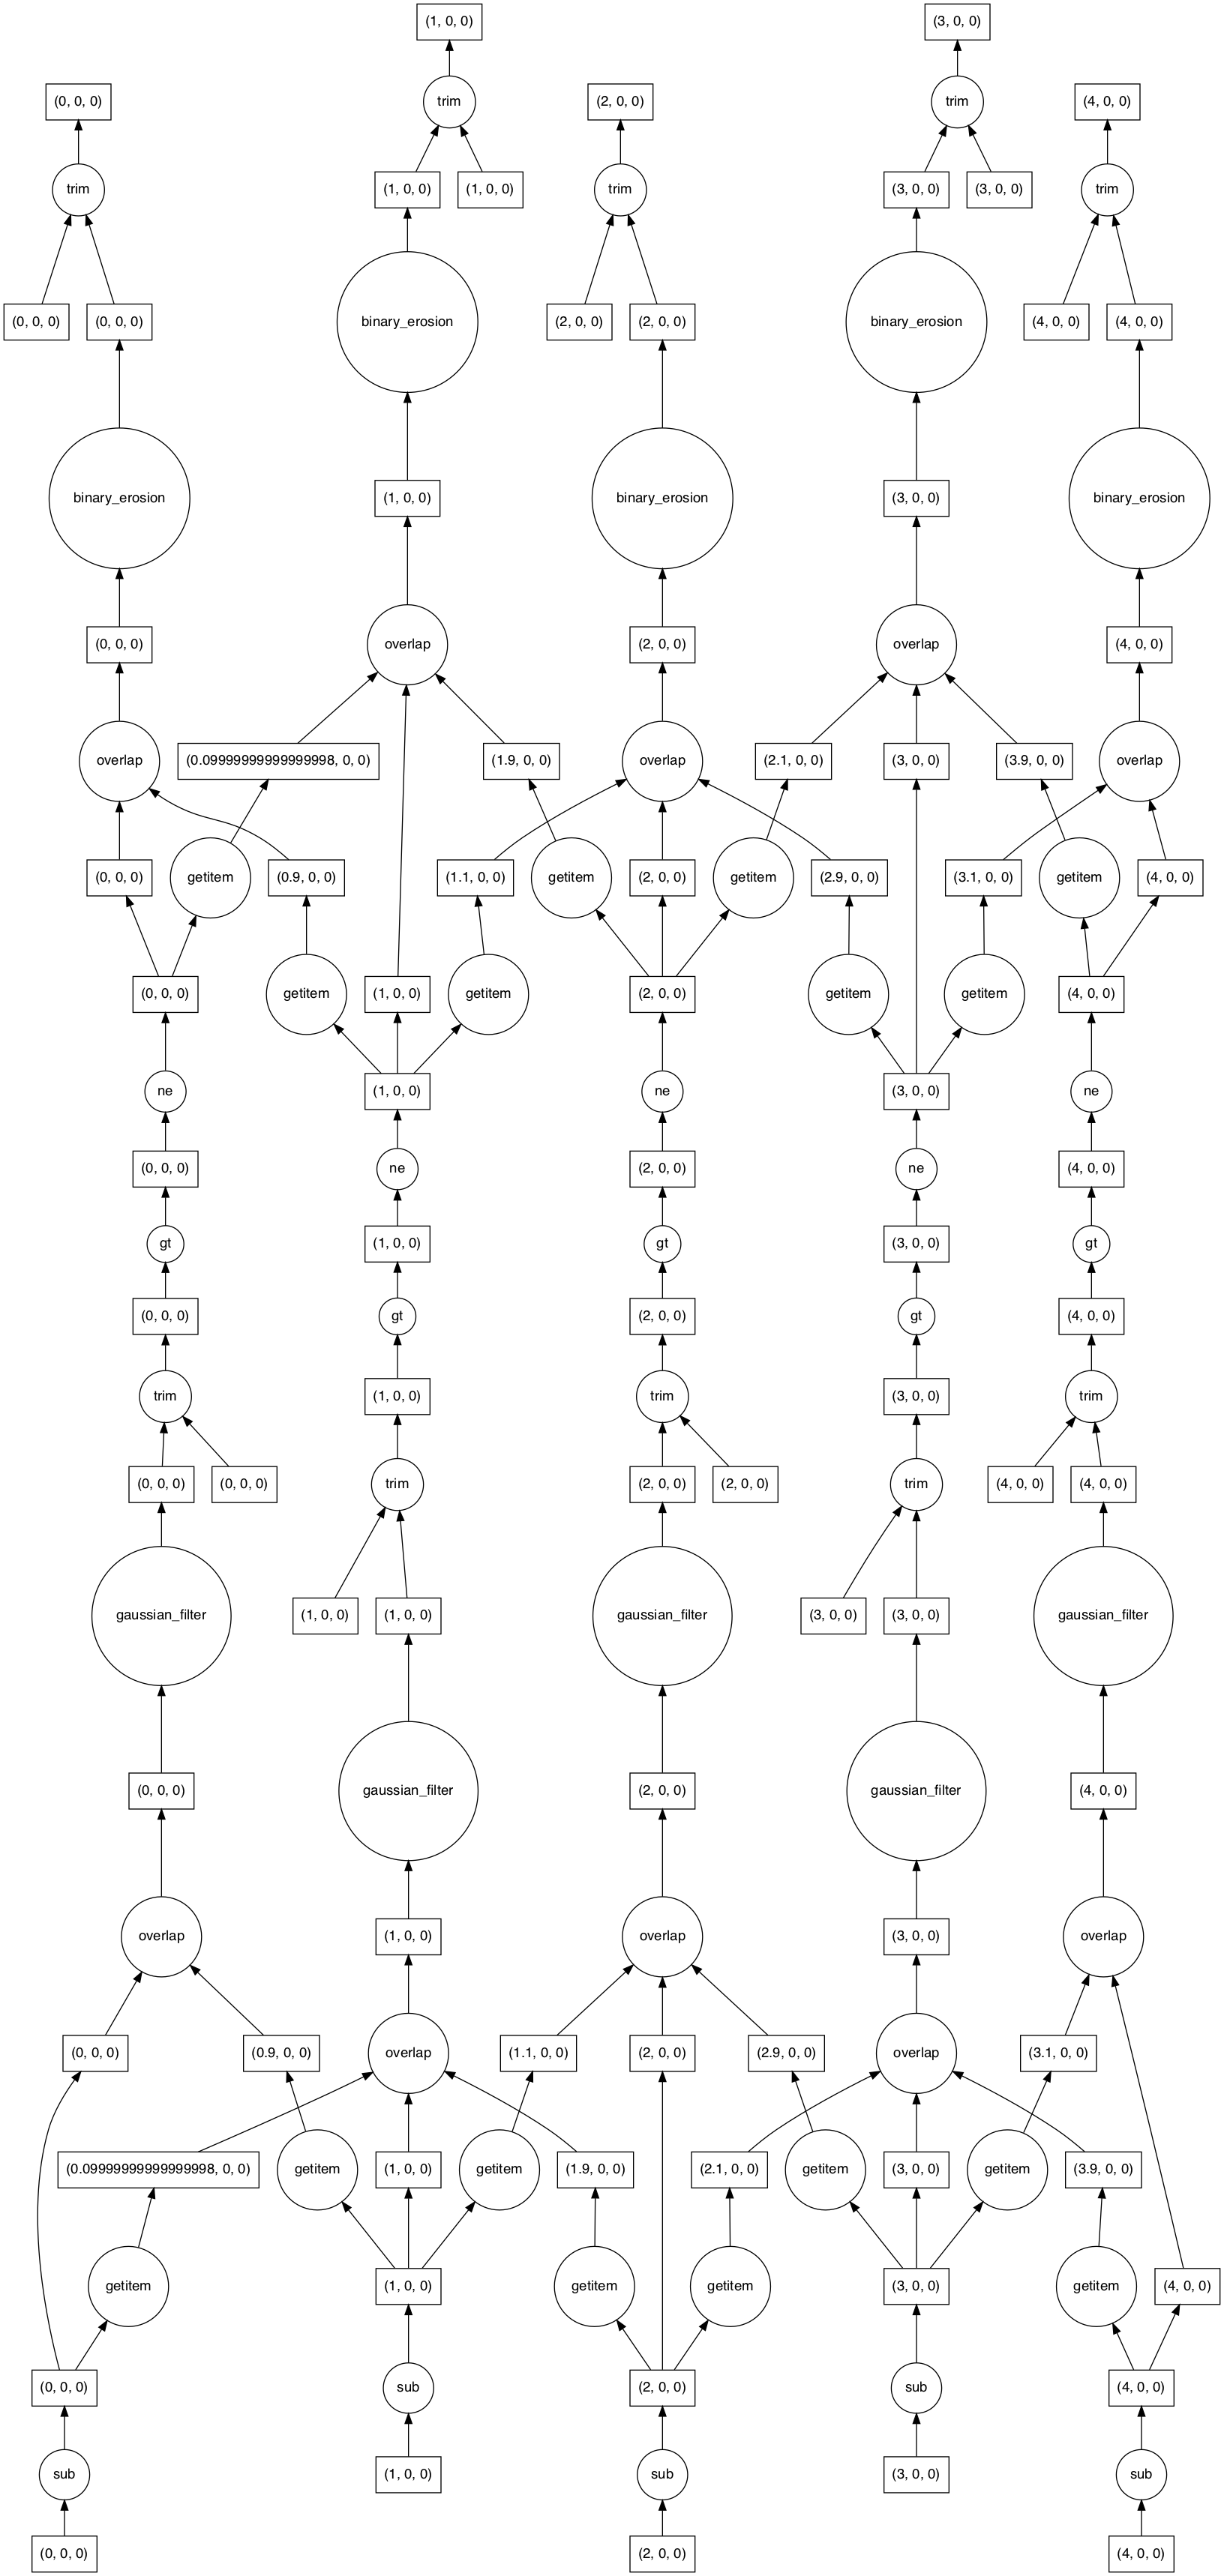

In [41]:
import dask_ndmorph as ndmorph
from skimage.morphology import ball
erode_foam = ndmorph.binary_erosion(image_filt > 0.9, ball(12))
dot_graph(erode_foam.dask)

### Label the items in the image
- Create a label function
- Labels must be globally unique 

In [26]:
from scipy.ndimage import label


def block_label(in_block, block_id=None):
    slice_no = block_id[0]
    offset = (np.prod(in_block.shape)*slice_no).astype(np.int64)
    label_img = label(in_block)[0].astype(np.int64)
    label_img[label_img > 0] += offset
    return label_img


lab_bubbles = erode_foam.map_blocks(block_label, dtype='int64')

In [27]:
with diag.ProgressBar(), diag.Profiler() as prof, diag.ResourceProfiler(0.5) as rprof:
    processed_stack = lab_bubbles.compute(num_workers=4)

[########################################] | 100% Completed |  9.0s


### Results of running the DAG

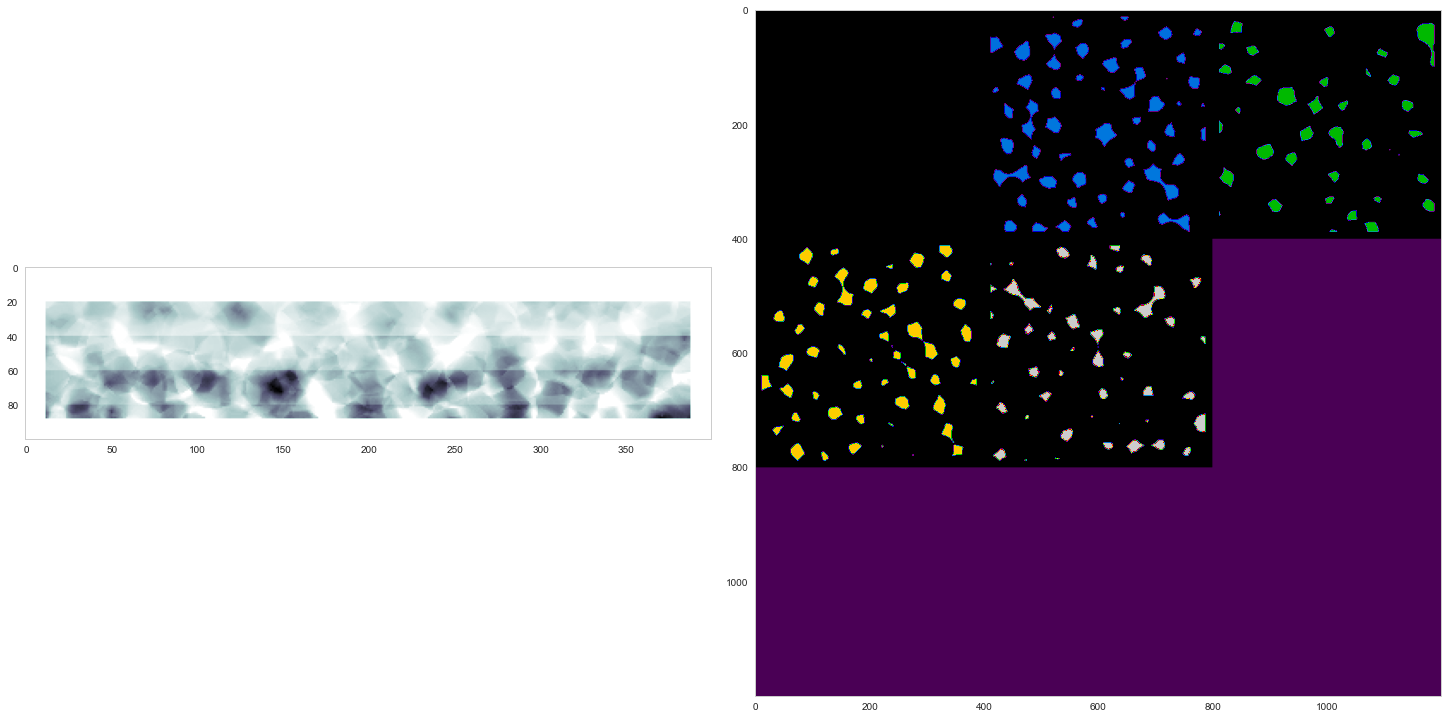

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(np.sum(processed_stack, 1), cmap='bone_r')
ax2.imshow(montage2d(processed_stack[::20]), cmap='nipy_spectral');

#### Profiler output

In [29]:
diag.visualize([prof, rprof]);

## The importance of operation order
- Select a slice and filter
- Filter and select a slice

In [37]:
foam_slices_da = da.from_array(
    foam_stack/255.0, chunks=(10, 500, 500), name='FoamSlices')

filt_slices    = da_ndfilt.gaussian_filter(foam_slices_da, sigma=(1.0, 9, 9))
single_slice   = filt_slices[50]

single_slice.visualize(filename="singleslice.svg", optimize_graph=True);
filt_slices.visualize(filename="filtslices.svg"  , optimize_graph=True);

### Compare performance

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.4s


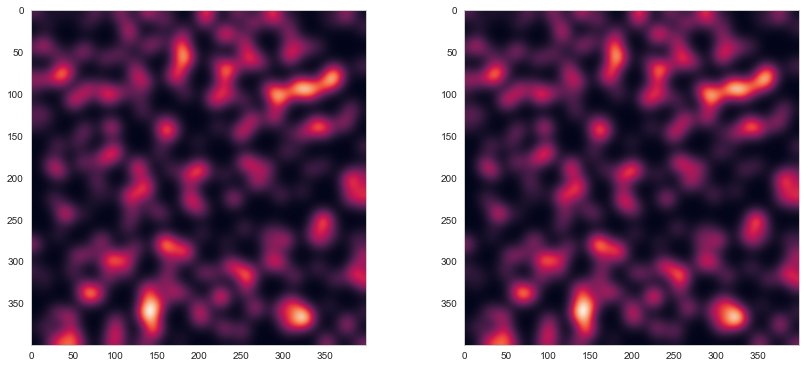

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
with diag.ProgressBar():
    ax1.imshow(single_slice.compute(num_workers=4))
    ax2.imshow(filt_slices.compute(num_workers=4)[50])

__Same output but different timing!__

### What happened?

<table>
<cols width=700px />
<tr><th>
    
__Select a slice and filter__
    
</th><th>
    
__Filter and select a slice__
    
</th></tr>    
<tr><td>
    
- A single slice only activates the chunks needed (lazy evaluation)
- 3 Chunks are processed

</td><td>

- The image is divded into 10 chunks
- All chunks are processed
- The slice is taken from the result

</td></tr>

<tr><td>
<center><img src="singleslice.svg" style="height:300px"/></center>
</td><td>
    <center>
<img src="filtslices.svg" style="height:300px"/></center>
</td></tr>
</table>


# Cloud computing

## Motivation for Cloud Computing

<div class="row">
<div class="column">
    
### Local recources
- Local resources are expensive and underutilized
- Management and updates are expensive and require dedicated IT staff

![Cloud Computing](figures/Efficiency.png)

</div>    
<div class="column"> 

### Cloud Resources

- Automatically setup
- "Unlimited" potential capacity and storage
- Cluster management already setup
- Common tools with many people using the same
    
</div>    
</div>

## Spark - A rich, heavily developed platform

### Available Tools
Tools built for table-like data data structures and much better adapted to it. 
 - [K-Means](https://github.com/apache/spark/blob/master/examples/src/main/scala/org/apache/spark/examples/SparkKMeans.scala), 
 - [Matrix Factorization](https://amplab.cs.berkeley.edu/projects/dfc-%C2%A0divide-and-conquer-matrix-factorization/), [Genomics](https://amplab.cs.berkeley.edu/projects/dna-processing-pipeline/), [Graph Analytics](https://amplab.cs.berkeley.edu/projects/graphx/), [Machine Learning](https://amplab.cs.berkeley.edu/projects/mlbase/)

### Commercial Support

Dozens of major companies (Apple, Google, Facebook, Cisco, ...) donate over \$30M a year to development of Spark and the Berkeley Data Analytics Stack 
- 2 startups in the last 6 months with seed-funding in excess of $15M each

### Academic Support

- All source code is available on GitHub
 - Elegant (20,000 lines vs my PhD of 75,000+)
- No patents or restrictions on usage
- Machine Learning Course in D-INFK next semester based on Spark

## Beyond: Streaming


### Post-processing goals
- Analysis done in weeks instead of months
- Some real-time analysis and statistics

### Streaming
- Can handle static data 
- or live data coming in from a 'streaming' device like a camera to do real-time analysis.

The exact same code can be used for real-time analysis and static code

### Scalability
- Connect more computers. 
- Start workers on these computer.

## Beyond: Approximate Results


Projects at AMPLab like Spark and BlinkDB are moving towards approximate results.
- Instead of ```mean(volume)```
 - ```mean(volume).within_time(5)```
 - ```mean(volume).within_ci(0.95)```

For real-time image processing it might be the only feasible solution and could drastically reduce the amount of time spent on analysis.

# Summary

- More can be done in parallel
- Limited resources, redundancy, race conditions
- Cloud computing
- DAGs